# Factoring Failure-Inducing Inputs

The problem of the original delta debugging (and its descendents) is that if one has a failure inducing input, which contains multiple independent, but overlapping faults, each of which results in crashes that can not be differentiated, then during test input minimization, only one of these inputs will be found. We show how to extract all independent faults from a given input string.

We start by importing the prerequisites.

In [1]:
from enum import Enum
import copy

## Linear Delta Debug

### Predicate

First, we define a way to capture the status of an input. There can be four outcomes when an input is executed:

* Success (failure condition reproduced)
* Failed (failure condition not reproduced)
* Invalid (Did not reach failure condition -- possibly semantically invalid)
* Timeout (equivalant to Failed)

In [2]:
class PRes(str, Enum):
    success = 'SUCCESS'
    failed = 'FAILED'
    invalid = 'INVALID'
    timeout = 'TIMEOUT'

Next, we define our predicate. Our error condition is when either `< ... select ... >` or `< ... option ... >` is present in the input.

In [3]:
import re

In [4]:
def simple_error(inp):
    if re.match(r'.*<.*(select|option).*>.*', inp):
        return PRes.success
    else:
        return PRes.failed

In [5]:
strings = [
'<select>',
'<option>',
'ab<opt>cd',
'abc<option>def',
'<<option>',
'<opt>cd',
'aa<option>xx<select>',
'abc<option select>def'    
]

In [6]:
for s in strings:
    print(simple_error(s))

PRes.success
PRes.success
PRes.failed
PRes.success
PRes.success
PRes.failed
PRes.success
PRes.success


### DDMin

In [7]:
import random
import string

Given a partition length, we want to split the string into that many partitions, remove each partition one at a time from the string, and check if for any of them, the causal() succeeds. If it succeeds for any, then return the succeeding string.

In [8]:
def remove_check_each_fragment(instr, start, part_len, causal):
    for i in range(start, len(instr), part_len):
        stitched =  instr[:i] + instr[i+part_len:]
        if causal(stitched): return i, stitched
    return -1, instr

The main function. We start by the smallest number of partitions – 2. Then, we check by removing each fragment for success. If removing one fragment succeeds, we change the current string to the string without that fragment. Since we succeeded in removing one fragment at this partition length, we do not know if we can remove other parts of the string. So, we want to redo with the same fragment length, so we keep the current partition length.

If none of the fragments could be removed, then it is time to decrease the partition length. We reduce the partition length by half.

If the partition length is now single chars, then we break and return.

In [9]:
def ddmin(cur_str, causal_fn):
    start, part_len = 0, len(cur_str) // 2
    while part_len >= 1:
        start, cur_str = remove_check_each_fragment(cur_str, start, part_len, causal_fn)
        if start != -1:
            if not cur_str: return ''
        else:
            start, part_len = 0, part_len // 2
    return cur_str

The driver.

In [10]:
def my_predicate(s):
    return simple_error(s) == PRes.success

In [11]:
strings_to_minimize = [s for s in strings if simple_error(s) == PRes.success]

In [13]:
for s in strings_to_minimize:
    print('Input:',repr(s))
    solution = ddmin(s, my_predicate)
    print(solution)

Input: '<select>'
<select>
Input: '<option>'
<option>
Input: 'abc<option>def'
<option>
Input: '<<option>'
<option>
Input: 'aa<option>xx<select>'
<select>
Input: 'abc<option select>def'
<select>


As can be seen above, running `ddmin` can result in identifying only a single fault when multiple faults are present.

A simple solution is to generate `N` input strings each string missing one delta each, and then run `ddmin` on each.

In [14]:
def factor_fii(inputstr):
    results = set()
    one_minus = [inputstr[:i] + inputstr[i+1:] for i in range(len(inputstr))]
    for s in [inputstr] + one_minus:
        if my_predicate(s):
            solution = ddmin(s, my_predicate)
            results.add(solution)
    return results

In [15]:
factor_fii('<option select>')

{'<option>', '<select>'}

In [16]:
for s in strings_to_minimize:
    print('Input:',repr(s))
    solution = factor_fii(s)
    print(solution)

Input: '<select>'
{'<select>'}
Input: '<option>'
{'<option>'}
Input: 'abc<option>def'
{'<option>'}
Input: '<<option>'
{'<option>'}
Input: 'aa<option>xx<select>'
{'<option>', '<select>'}
Input: 'abc<option select>def'
{'<option>', '<select>'}


## Hierarchical Delta Debug

The challenge is how to lift this solution to hierarchical delta debugging and its variants. The question is, how to map the deletion of deltas to trees. A simple solution to this problem is to look at the terminal symbols. We need to remove the influence of a terminal symbol one at a time. For terminal symbols with no siblings, this is easy. Simply replace the nonterminal parent with `<nt_name>` (this can become complicated if `<nt_name>` expands only to that particular teerminal). For terminal symbols with siblings however, things become more complicated. One general solution is to look for recursion. For nonterminals with recursion, one can remove the influence of its child terminal symbols by replacing that node with any of the child nodes with the same nonterminal symbol, using each child resulting in a different whole string. **Each terminal should be removed at least once**. That is, each parent node of the terminal symbols should be replaced by `<nt_name>` along with the with child replacement.

Next, we define our predicate. It is a simple test for doubled parenthesis such as `((..))` or an expression `0 / 0`

In [47]:
def expr_double_paren(inp):
    if re.match(r'.*[(][(].*[)][)].*', inp):
        return PRes.success
    if re.match(r'.*0 / 0.*', inp):
        return PRes.success
    return PRes.failed

In [48]:
my_predicate = expr_double_paren

We also define an input.

In [49]:
expr_input =  '1 + ((2 * 3 / 4))'

In [50]:
my_input = expr_input

We verify that we can reproduce the failing condition correctly.

In [51]:
assert my_predicate(my_input) == PRes.success

In [52]:
assert my_predicate('(1 + 2)') == PRes.failed

In [54]:
assert my_predicate('0 / 0') == PRes.success

### Grammar

A context-free grammar is represented as a Python dict, with each nonterminal symbol forming a key, and each nonterminal _defined_ by a list of expansion rules. For example, the expression grammar for parsing arithmetic expressions is given below.

In [55]:
EXPR_GRAMMAR = {'<start>': [['<expr>']],
 '<expr>': [['<term>', ' + ', '<expr>'],
  ['<term>', ' - ', '<expr>'],
  ['<term>']],
 '<term>': [['<factor>', ' * ', '<term>'],
  ['<factor>', ' / ', '<term>'],
  ['<factor>']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<integer>', '.', '<integer>'],
  ['<integer>']],
 '<integer>': [['<digit>', '<integer>'], ['<digit>']],
 '<digit>': [['0'], ['1'], ['2'], ['3'], ['4'], ['5'], ['6'], ['7'], ['8'], ['9']]}

In [56]:
EXPR_G = {'[start]': '<start>', '[grammar]': EXPR_GRAMMAR}

Note the convetion we used: Each nonterminal is enclosed in angle brackets. E.g. `<expr>`. We now define a function that can distinguish terminal symbols from nonterminals.

The `is_nt()` function checks if the given node is a terminal or not.

In [57]:
def is_nt(symbol):
     return symbol and (symbol[0], symbol[-1]) == ('<', '>')

#### The parser

Given the grammar, and an input, we can parse it into a derivation tree.
The `Parser` below is from [fuzzingbook.org](https://www.fuzzingbook.org/html/Parser.html), and provides a generic context-free parser. This is present in the `src` directory.

In [58]:
from Parser import EarleyParser as Parser

How do we check that our parse succeeded? We can convert the derivation tree back to the original string and check for equality.

The `tree_to_string()` function converts a derivation tree to its original string.

In [59]:
def tree_to_string(tree, wrap=lambda ntree, depth, name, string: string, depth=0):
    name, children, *rest = tree
    if not is_nt(name):
        return name
    else:
        return wrap(tree, depth, name, ''.join([tree_to_string(c, wrap, depth-1) for c in children]))

In [60]:
expr_parser = Parser(EXPR_GRAMMAR, start_symbol='<start>', canonical=True)
parsed_expr = list(expr_parser.parse(my_input))[0]
tree_to_string(parsed_expr)

'1 + ((2 * 3 / 4))'

#### Graphical trees

While converting to strings are easy, it is unsatisfying. We want to make our output look pretty, and inspect the tree structure of the parsed tree. So we define graphical tree display (code from fuzzingbook)

In [61]:
from graphviz import Digraph

In [62]:
from IPython.display import display, Image

In [63]:
def zoom(v, zoom=True):
    # return v directly if you do not want to zoom out.
    if zoom:
        return Image(v.render(format='png'))
    return v

In [64]:
def extract_node(node, id):
    symbol, children, *annotation = node
    return symbol, children, ''.join(str(a) for a in annotation)
def node_attr(dot, nid, symbol, ann): dot.node(repr(nid), symbol)
def edge_attr(dot, start_node, stop_node): dot.edge(repr(start_node), repr(stop_node))
def graph_attr(dot): dot.attr('node', shape='plain')
def display_tree(derivation_tree):
    counter = 0
    def traverse_tree(dot, tree, id=0):
        (symbol, children, annotation) = extract_node(tree, id)
        node_attr(dot, id, symbol, annotation)
        if children:
            for child in children:
                nonlocal counter
                counter += 1
                child_id = counter
                edge_attr(dot, id, child_id)
                traverse_tree(dot, child, child_id)
    dot = Digraph(comment="Derivation Tree")
    graph_attr(dot)
    traverse_tree(dot, derivation_tree)
    return dot

We are now ready to display the tree structure.

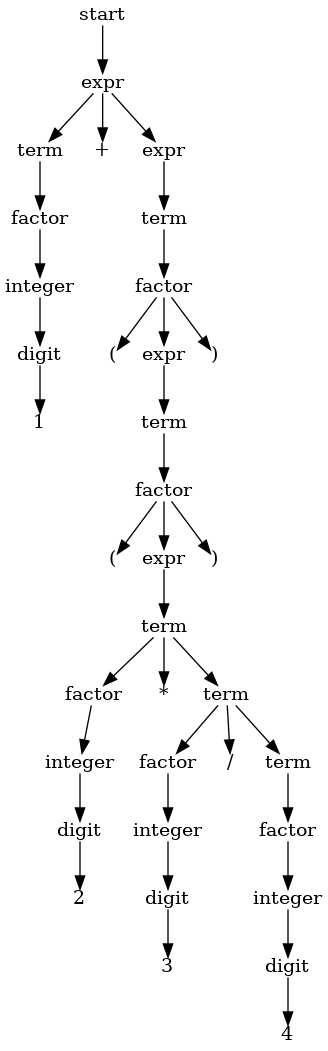

In [65]:
zoom(display_tree(parsed_expr))

### Factorization

First we need to find recursive nodes

In [66]:
def find_reachable_keys(grammar, key, reachable_keys=None, found_so_far=None):
    if reachable_keys is None: reachable_keys = {}
    if found_so_far is None: found_so_far = set()

    for rule in grammar[key]:
        for token in rule:
            if not is_nt(token): continue
            if token in found_so_far: continue
            found_so_far.add(token)
            if token in reachable_keys:
                for k in reachable_keys[token]:
                    found_so_far.add(k)
            else:
                keys = find_reachable_keys(grammar, token, reachable_keys, found_so_far)
                # reachable_keys[token] = keys <- found_so_far contains results from earlier
    return found_so_far

In [68]:
reachable = {}
for key in EXPR_GRAMMAR:
    keys = find_reachable_keys(EXPR_GRAMMAR, key, reachable)
    print(key, keys)

<start> {'<term>', '<integer>', '<digit>', '<factor>', '<expr>'}
<expr> {'<term>', '<integer>', '<digit>', '<factor>', '<expr>'}
<term> {'<term>', '<integer>', '<digit>', '<factor>', '<expr>'}
<factor> {'<term>', '<integer>', '<digit>', '<factor>', '<expr>'}
<integer> {'<integer>', '<digit>'}
<digit> set()


In [69]:
def find_recursive_keys(grammar):
    reachable = {}
    found_so_far = {}
    for key in grammar:
        keys = find_reachable_keys(grammar, key, reachable)
        found_so_far[key] = keys
    recursive = []
    for k in found_so_far:
        if k in found_so_far[k]:
            recursive.append(k)
    return recursive

In [70]:
find_recursive_keys(EXPR_GRAMMAR)

['<expr>', '<term>', '<factor>', '<integer>']

Next, we need to do two things:
1. For each terminal, find the parent, and add the abstract pattern with `<parentname>` in the parent's place in the list of strings.
2. For each such parent, check if the parent is recursive, and if it is, then, replace the node with this child node, and each string thus generated gets added to list of strings.

## Reduction

We are now ready to define our delta debugging reduction phase. We use the **Perses** algorithm. The algorithm is as follows: We start the root, and recursively go down the child nodes. For each node, we check if that node can be replaced by a subtree with the same nonterminal, and still reproduce the failure, and find the smallest such tree (length determined by number of leaves).

Since this procedure can result in multiple trees, the tree to work on is chosen based on a priority queue where the priority is given to the smallest tree.

The particular node chosen to replace the current node is determined based first on its numer of leaf nodes, and then on its rank in a priority queue, where the priority is determined by the depth of the subtree from the current node. That is, a child gets priority over a grand child.

We first have to define a way to address a specific node.

In [ ]:
t = parsed_expr[1][0][1][2][1][0]
zoom(display_tree(t))

In [ ]:
tree_to_string(t)

For the path, we simply use a list of numbers indicating the child node. For example, in the above, the path would be `[0, 2, 0]`

Given a path, `get_child()` will simply return the node at the path.

In [ ]:
def get_child(tree, path):
    if not path: return tree
    cur, *path = path
    return get_child(tree[1][cur], path)

In [ ]:
te = get_child(parsed_expr, [0, 2, 0])
zoom(display_tree(te))

In [ ]:
tree_to_string(te)

We also need a way to replace one node with another. This is done by `replace_path()`.

In [ ]:
def replace_path(tree, path, new_node=None):
    if new_node is None: new_node = []
    if not path: return copy.deepcopy(new_node)
    cur, *path = path
    name, children, *rest = tree
    new_children = []
    for i,c in enumerate(children):
        if i == cur:
            nc = replace_path(c, path, new_node)
        else:
            nc = c
        if nc:
            new_children.append(nc)
    return (name, new_children, *rest)

In [ ]:
t = parsed_expr[1][0][1][2][1][0]
zoom(display_tree(t))

In [ ]:
tree_to_string(t)

In [ ]:
te = replace_path(parsed_expr, [0, 2, 0], [])
zoom(display_tree(te))

In [ ]:
tree_to_string(te)

In [ ]:
tn = replace_path(parsed_expr, [0, 2, 0], ('x',[]))
zoom(display_tree(tn))

In [ ]:
tree_to_string(tn)

### Priority queue

For perses reduction, one needs a way to count the number of leaf nodes to determine the priority of a node. This is done by `count_leaves()`

In [ ]:
import heapq

In [ ]:
def count_leaves(node):
    name, children, *_ = node
    if not children:
        return 1
    return sum(count_leaves(i) for i in children)

In [ ]:
count_leaves(parsed_expr)

In [ ]:
count_leaves(te)

We also define a helper that simply counts the internal nodes.

In [ ]:
def count_nodes(node):
    name, children, *_ = node
    if not children:
        return 0
    return sum(count_nodes(i) for i in children) + 1

In [ ]:
count_nodes(parsed_expr)

Next, we need to maintain a priority queue of the `[(tree, path)]`. The essential idea is to prioritize the items first by the number of leaves in  the full tree (that is, the smallest tree that we have currently gets priority), then next by the number of leaves in the node pointed to by path, and finally, tie break by the insertion order (`ecount`).

In [ ]:
ecount = 0

In [ ]:
def add_to_pq(tup, q):
    global ecount
    dtree, F_path = tup
    stree = get_child(dtree, F_path)
    n =  count_leaves(dtree)
    m =  count_leaves(stree)
    # heap smallest first
    heapq.heappush(q, (n, m, -ecount, tup))
    ecount += 1

We define another helper function `nt_group()` that groups all nonterminals that have the same name. These are used to determine the nodes that can be used to replace one node.

In [ ]:
def nt_group(tree, all_nodes=None):
    if all_nodes is None: all_nodes = {}
    name, children, *_ = tree
    if not is_nt(name): return
    all_nodes.setdefault(name, []).append(tree)
    for c in children:
        nt_group(c, all_nodes)
    return all_nodes

In [ ]:
gp = nt_group(te)
for key in gp:
    print(key)
    for node in gp[key]:
        print(tree_to_string(node))

What are the compatible nodes? These are all the nodes that have the same nonterminal name, and is a descendent of the current node. Further, if the nonterminal allows empty node, then this is the first in the list. This is defined by `compatible_nodes()`

In [ ]:
def compatible_nodes(tree, grammar):
    key, children, *_ = tree
    # Here is the first choice. Do we restrict ourselves to only children of the tree
    # or do we allow all nodes in the original tree? given in all_nodes?
    lst = nt_group(tree)
    node_lst = [(i, n) for i,n in enumerate(lst[key])]

    # insert empty if the grammar allows it as the first element
    if [] in grammar[key]: node_lst.insert(0, (-1, (key, [])))
    return node_lst

In [ ]:
get_child(te, [0])

In [ ]:
compatible_nodes(get_child(te, [0]), EXPR_GRAMMAR)

Some programming languages have `tokens` which are first level lexical elements. The parser is often defined using the lexer tokens. We do not want to try to reduce tokens further. So we define a way to identify them (we have to keep in mind when we produce grammars).

In [ ]:
def is_token(val):
    assert val != '<>'
    assert (val[0], val[-1]) == ('<', '>')
    if val[1].isupper(): return True
    #if val[1] == '_': return val[2].isupper() # token derived.
    return False

### Perses reduction

We finally define the reduction algorithm. The implementation of __Perses__ is given in `reduction()`. The essential idea is as follows:

1. We have a priority queue of (tree, path_to_node) structures, where node is a node within the tree.
 * The highest priority is given to the smallest tree.
 * With in the nodes in the same tree, priority is given to nodes with smallest number of leaves
 * In case of tie break, the shallowest subnode gets the highest priority (i.e child has higher priority over grand child, and empty node has the highest priority since it is a peer of the current node).
2. We pick each nodes, and find compatible subnodes that reproduce the failure.
3. Each compatible node and the corresponding tree is put back into the priority queue.
4. If no child nodes were found that could replace the current node, then we add each children with the current tree into the priority queue. (If we had to recurse into the child nodes, then the next tree that will get picked will be a different tree.)

In [ ]:
def reduction(tree, grammar, predicate):
    first_tuple = (tree, [])
    p_q = []
    add_to_pq(first_tuple, p_q)

    ostr = tree_to_string(tree)
    assert predicate(ostr) == PRes.success
    failed_set = {ostr: True}

    min_tree, min_tree_size = tree, count_leaves(tree)
    while p_q:
        # extract the tuple
        _n, _m, _ec, (dtree, F_path) = heapq.heappop(p_q)
        stree = get_child(dtree, F_path)
        skey, schildren = stree
        found = False
        # we now want to replace stree with alternate nodes.
        for i, node in compatible_nodes(stree, grammar):
            # replace with current (copy).
            ctree = replace_path(dtree, F_path, node)
            if ctree is None: continue # same node
            v = tree_to_string(ctree)
            if v in failed_set: continue
            failed_set[v] = predicate(v) # we ignore PRes.invalid results
            if failed_set[v] == PRes.success:
                found = True
                ctree_size = count_leaves(ctree)
                if ctree_size < min_tree_size: min_tree, min_tree_size = ctree, ctree_size

                if v not in failed_set:
                    print(v)
                t = (ctree, F_path)
                assert get_child(ctree, F_path) is not None
                add_to_pq(t, p_q)

        # The CHOICE here is that we explore the children if and only if we fail
        # to find a node that can replace the current
        if found: continue
        if is_token(skey): continue # do not follow children TOKEN optimization
        for i, child in enumerate(schildren):
            if not is_nt(child[0]): continue
            assert get_child(tree=dtree, path=F_path + [i]) is not None
            t = (dtree, F_path + [i])
            add_to_pq(t, p_q)
    return min_tree

In [ ]:
er = reduction(parsed_expr, EXPR_GRAMMAR, my_predicate)
zoom(display_tree(er))

In [ ]:
tree_to_string(er)

## A Fuzzer

In order to define abstraction, we need to be able to generate values based on a grammar. Our fuzzer is able to do that.

In [ ]:
import random

### The interface

In [ ]:
class Fuzzer:
    def __init__(self, grammar):
        self.grammar = grammar

    def fuzz(self, key='<start>', max_num=None, max_depth=None):
        raise NotImplemented()

### The implementation

The fuzzer tries to randomly choose an expansion when more than one expansion is available. If however, it goes beyond max_depth, then it chooses the cheapest nodes. The cheapest nodes are those nodes with minimum further expansion (no recursion).

In [ ]:
class LimitFuzzer(Fuzzer):
    def symbol_cost(self, grammar, symbol, seen):
        if symbol in self.key_cost: return self.key_cost[symbol]
        if symbol in seen:
            self.key_cost[symbol] = float('inf')
            return float('inf')
        v = min((self.expansion_cost(grammar, rule, seen | {symbol})
                    for rule in grammar.get(symbol, [])), default=0)
        self.key_cost[symbol] = v
        return v

    def expansion_cost(self, grammar, tokens, seen):
        return max((self.symbol_cost(grammar, token, seen)
                    for token in tokens if token in grammar), default=0) + 1

    def gen_key(self, key, depth, max_depth):
        if key not in self.grammar: return key
        if depth > max_depth:
            assert key in self.cost
            clst = sorted([(self.cost[key][str(rule)], rule) for rule in self.grammar[key]])
            rules = [r for c,r in clst if c == clst[0][0]]
        else:
            rules = self.grammar[key]
        return self.gen_rule(random.choice(rules), depth+1, max_depth)

    def gen_rule(self, rule, depth, max_depth):
        return ''.join(self.gen_key(token, depth, max_depth) for token in rule)

    def fuzz(self, key='<start>', max_depth=10):
        return self.gen_key(key=key, depth=0, max_depth=max_depth)

    def __init__(self, grammar):
        super().__init__(grammar)
        self.key_cost = {}
        self.cost = self.compute_cost(grammar)

    def compute_cost(self, grammar):
        cost = {}
        for k in grammar:
            cost[k] = {}
            for rule in grammar[k]:
                cost[k][str(rule)] = self.expansion_cost(grammar, rule, set())
        return cost

In [ ]:
expr_fuzzer = LimitFuzzer(EXPR_GRAMMAR)
expr_fuzzer.fuzz()

## Abstraction

We can now start to define abstraction.

### Mark the abstract nodes

Give a list of paths that were verified as abstract, we go through each, and mark them abstract in the same tree.

In [ ]:
def mark_verified_abstract_path(tree, path):
    name, children = get_child(tree, path)
    new_tree = replace_path(tree, path, (name, children, {'abstract': True}))
    return new_tree

In [ ]:
mark_verified_abstract_path(te, [0])

In [ ]:
def mark_verified_abstract(tree, verified_paths):
    for path in verified_paths:
        tree = mark_verified_abstract_path(tree, path)
    return tree

In [ ]:
at = mark_verified_abstract(te, ([0,0], [0,2])); at

A method to mark everything else as concrete.

In [ ]:
def mark_concrete(tree):
    name, children, *abstract_a = tree
    abstract = {'abstract': False} if not abstract_a else abstract_a[0]
    return (name, [mark_concrete(c) for c in children], abstract)

In [ ]:
t = mark_concrete(at); t

A way to display the abstracted tree

In [ ]:
def till_abstract(node):
    name, children, *rest = node
    if rest[-1]['abstract']:
        return (name + '*', [])
    return (name, [till_abstract(c) for c in children], *rest)

In [ ]:
zoom(display_tree(till_abstract(t)))

Next, we define a method that given a list of paths, will replace each of these nodes with random values.

In [ ]:
def replace_arr_with_random_values(npath_arr, grammar, tree):
    if not npath_arr: return tree
    npath, *npath_arr = npath_arr
    node = get_child(tree, npath)
    gf = LimitFuzzer(grammar)
    e = gf.fuzz(key=node[0])
    ntree = replace_path(tree, npath, [node[0], [(e, [])]])
    assert ntree is not None
    return replace_arr_with_random_values(npath_arr, grammar, ntree)

In [ ]:
rt = replace_arr_with_random_values([[0, 0], [0, 2]], EXPR_GRAMMAR, t); rt

In [ ]:
zoom(display_tree(rt))

A wrapper for the `replace_arr_with_random_values()`

In [ ]:
def generate(dtree, grammar, paths):
    res = replace_arr_with_random_values([p[0] for p in paths], grammar, dtree)
    return tree_to_string(res)

### Check if we can generalize a node

We now define `can_generalize()`. This function takes a current path, the derivation tree, the grammar, predicate and a list of unverified paths the maximum number of checks (`max_checks`), and produces `max_checks` number of inputs where every node in unverified and the current node in `tval` is replaced with random values. This is then checked to see if the resulting input reproduces the failure. This way, we can verify that `tval` can be generalized even when other abstract nodes are replaced with random values.

In [ ]:
MAX_CHECKS=100
MAX_LIMIT=1000
FIND_COUNTER_EXAMPLE=True
MIN_EXAMPLES=1

In [ ]:
def can_generalize(tval, dtree, grammar, predicate, unverified, max_checks):
    checks = 0
    limit = 0
    abstract = True
    rstr = None
    checks = set()
    while len(checks) < max_checks:
        limit += 1
        if limit >= MAX_LIMIT:
            # giveup.
            if FIND_COUNTER_EXAMPLE:
                if len(checks) > MIN_EXAMPLES:
                    abstract = True
                else:
                    abstract = False
            else:
                abstract = False
            path, status = tval
            node = get_child(dtree, path)
            print('warn: giving up', node[0], 'after', MAX_LIMIT,
                    'and no counterexample found.'
                    'with', len(checks),
                    'valid values abstract:', abstract)
            break
        rstr = generate(dtree, grammar, [tval] + unverified)
        pres = predicate(rstr)
        if pres == PRes.failed:
            abstract = False
            break
        else:
            if pres == PRes.success:
                checks.add(rstr)
            else:
                continue
    return abstract

In [ ]:
first_expr = [0]
display_tree(get_child(er, first_expr))

In [ ]:
second_expr = [0,0,0,1]
display_tree(get_child(er, second_expr))

In [ ]:
third_expr = [0,0,0,1,0,0,1]
display_tree(get_child(er, third_expr))

In [ ]:
class St(Enum):
    unchecked = 1
    unverified = -1
    verified = 0

In [ ]:
can_generalize((second_expr, St.unchecked), er, EXPR_GRAMMAR, my_predicate, [], 100)

In [ ]:
can_generalize((third_expr, St.unchecked), er, EXPR_GRAMMAR, my_predicate, [], 100)

The `abstraction()` uses `can_generalize()` to check whether each node can be abstracted. The main job of `abstraction()` is to recurse into the child nodes when a previously abstract node is marked as concrete.

In [ ]:
SKIP_IS_SPECIAL=True
SKIP_IS_CONCRETE = True
LOG=True
LOOK_DEEPER_IN_ISOLATED=True

In [ ]:
check_counter = 0

In [ ]:
def abstraction(tval, dtree, grammar, predicate, unverified, max_checks):
    global check_counter, KEY
    path, status = tval
    node = get_child(dtree, path)
    KEY = "%s:(%s) %s" % (node[0], tree_to_string(node), status)
    if LOG:
        print(check_counter, 'check:', node[0], status)
        check_counter += 1
    key, children, *rest = node
    if not children: return []
    if not is_nt(key): return []

    if key == '<_SKIP>' and SKIP_IS_SPECIAL:
        if SKIP_IS_CONCRETE: return []
        if status == St.unchecked:
            print('abstract: unverified', node[0])
            return [(path, St.unverified)]
        else:
            print('abstract: verified', node[0])
            return [(path, St.verified)]

    abstract = can_generalize(tval, dtree, grammar, predicate, unverified, max_checks)
    if abstract:
        if status == St.unchecked:
            print('abstract: unverified', node[0])
            return [(path, St.unverified)]
        else:
            print('abstract: verified', node[0])
            return [(path, St.verified)]
    else:
        if status == St.unverified:
            print('NOT ABSTRACT:', KEY)

        if is_token(key): return []
        paths = []
        # what should we do when an unverified node is found not abstract?
        # do we look at the child nodes? It can be costly, because now we
        # are also dealing with random values in other nodes marked general.
        if status == St.unchecked or LOOK_DEEPER_IN_ISOLATED:
            for i,child in enumerate(children):
                if not is_nt(child[0]): continue
                tval = (path + [i], St.unchecked)
                p = abstraction(tval, dtree, grammar, predicate, unverified, max_checks)
                paths.extend(p)
        return paths

In [ ]:
ab = abstraction((first_expr, St.unchecked), er, EXPR_GRAMMAR, my_predicate, [], 100); ab

In [ ]:
display_tree(get_child(er, ab[0][0]))

### Isolation

To isolate independent causes,  We first collect all nodes that can be independently generalized, and then check whether they are still generalizable even when other abstract marked nodes are replaced with random values.

In [ ]:
gen_counter = 0

In [ ]:
def isolation(tree, grammar, predicate, max_checks):
    def _path(v): return ','.join([str(i) for i in v[0]])
    def is_child(a, b):
        return len(a[0]) > len(b[0]) and _path(a).startswith(_path(b)) # a is child of b

    global gen_counter
    unverified = [([], St.unchecked)]
    verified = []
    original = []
    while unverified:
        v = unverified.pop(0)
        if LOG:
            node = get_child(tree, v[0])
            print(gen_counter, 'isolation:', node[0], v[1])
            gen_counter += 1
        _original = list(original)
        original.append(v)
        # problem here is, some of the original may be parent of some of the unverified
        # so, we want to avoid those unverified if they are already part of original
 
        # so we next remove any from original that is parent of current v
        _original = [o for o in _original if not is_child(v, o)]

        # remove from _original that is parent of any of itself.
        _original = [x for x in _original if not [o for o in _original if is_child(x, o)]]

        # next we remove from unverified any that is child of any in _original
        _unverified = list(unverified)
        _unverified = [u for u in _unverified if not [o for o in _original if is_child(u, o)]]
        print('O paths:')
        for p in (_original):
            node = get_child(tree, p[0])
            print("o>\t", p, "%s<%s>" % (node[0], repr(tree_to_string(node))))
        print()
        print('U paths:')
        for p in (_unverified):
            node = get_child(tree, p[0])
            print("u>\t", p, "%s<%s>" % (node[0], repr(tree_to_string(node))))
        print()
        
        newpaths = abstraction(v, tree, grammar, predicate, sorted(_unverified + _original), max_checks)
        print('current paths:')
        for p in newpaths:
            node = get_child(tree, p[0])
            print(">\t", p, "%s<%s>" % (node[0], repr(tree_to_string(node))))
        print()

        for p in newpaths:
            if p[1] == St.verified:
                verified.append(p)
            elif p[1] == St.unverified:
                unverified.append(p)
            else:
                assert false
    print('abstract paths:', len(verified))
    new_tree = mark_verified_abstract(tree, [p[0] for p in verified])
    # now change everything else to False
    return mark_concrete(new_tree)

In [ ]:
nt = replace_path(parsed_expr, [0, 0], get_child(er, [0, 0])); display_tree(nt)

In [ ]:
tree_to_string(nt)

In [ ]:
nt

In [ ]:
ist = isolation(nt, EXPR_GRAMMAR, my_predicate, 100); ist

In [ ]:
display_tree(till_abstract(ist))

### Context Sensitivity

In finding similar nodes, we have to give first preference
to the paths with maximum *amount* of common elements that can
be identified on a string in terms of character count. No
similarity analysis should be allowed on the nodes where a
previous analysis detected similarity

The essential idea here is to first find _concrete_ nodes, and
check their string representation one at a time with other concrete
nodes.

In [ ]:
def e_g(abstract_a):
    if not abstract_a:
        return True
    else:
        return abstract_a[0]['abstract']

In [ ]:
def identify_concrete_paths_to_nt(gtree, path=None):
    if path is None: path = []
    name, children, *_general = gtree
    general = e_g(_general)

    # we dont care about general non terminals
    if general and is_nt(name): return []
    # we dont care about terminals either
    if not is_nt(name): return []
    if name == '<_SKIP>': return []

    my_paths = [path]
    # for tokens we do not care about things below
    if is_token(name): return my_paths

    for i, c in enumerate(children):
        ps = identify_concrete_paths_to_nt(c, path + [i])
        my_paths.extend(ps)
    return my_paths

In [ ]:
nts = identify_concrete_paths_to_nt(ist); nts

In [ ]:
for nt in nts:
    print(nt, "          ", tree_to_string(get_child(ist, nt)))

Next, we need to find out of these nodes, which are similar

In [ ]:
def find_similar_nodes(gtree, cpaths, log=False):
    strings = {}
    for path in cpaths:
        n = get_child(gtree, path)
        s = tree_to_string(n)
        if not len(s): continue
        key = (n[0], s)
        strings.setdefault(key, []).append(path)
    if log:
        for k in strings:
            print(k)
            for q in strings[k]:
                print("  ", q)
    return {s:strings[s] for s in strings if len(strings[s]) > 1}

In [ ]:
find_similar_nodes(ist, nts, log=True)

How do we verify that two keys are abstractable but context sensitive? generate random values for them, and replace it in all instances, and verify that the faults can be reproduced.

In [ ]:
def are_these_similar(tkey, paths, grammar, gtree, predicate, max_checks=100):
    name, string = tkey
    if len(paths) < 2: return False
    gf = LimitFuzzer(grammar)
    nchecks = 0
    seen = set()
    global KEY
    KEY = 'similar: ' + name
    for i in range(max_checks):
        v = gf.fuzz(key=name)
        if v in seen: continue
        seen.add(v)
        # now replace it in all paths
        ctree = gtree
        for p in paths:
            ctree = replace_path(ctree, p, (name, [(v, [])]))
        res = tree_to_string(ctree)
        pr = predicate(res)
        if pr == PRes.failed:
            print(repr(v), repr(res))
            return False
        elif pr == PRes.success:
            continue
        elif pr == PRes.invalid  or pr == PRes.timeout:
            nchecks += 1

    if len(seen) <= 1: # a single
        return False

    # there has been at least one successful replacement
    return nchecks < max_checks

The `markup_paths` simply rename the context sensitive nodes with a `$` prefix. Since there can be multiple context sensitive nodes with the same nonterminal, but separate usages, we also append a number to them.

In [ ]:
nsym = 0

In [ ]:
def markup_paths(tkey, paths, gtree):
    global nsym
    nsym += 1
    name, string = tkey
    newname = '<$%s_%d>' % (name[1:-1], nsym)
    for p in paths:
        cname, children, gen = get_child(gtree, p)
        assert name == cname
        # now it is generalizable!
        gtree = replace_path(gtree, p, (newname, children, {'sensitive': True, 'abstract': True})) 
    return gtree

In [ ]:
def identify_similarities(grammar, predicate, generalized_tree, max_checks=100):
    cpaths = identify_concrete_paths_to_nt(generalized_tree)
    similar_nodes = find_similar_nodes(generalized_tree, cpaths)

    for key in similar_nodes:
        res = are_these_similar(key, similar_nodes[key], grammar, generalized_tree, predicate, max_checks)
        if res and len(similar_nodes[key]) > 1:
            generalized_tree = markup_paths(key, similar_nodes[key], generalized_tree)
        print('Similar?', key, res)
    # from_paths_identify_similar
    # for each similar verify if they can be fuzzed together.
    return generalized_tree

Finally we need to define the string representation of the tree. This is done by `general_str()`

In [ ]:
def general_str(tree):
    name, children, *general_ = tree
    if not is_nt(name): return name
    v = tree_to_string(tree)
    if not v.strip(): return v
    general = e_g(general_)
    if general:
        if is_nt(name):
            if name == '<>': return v
            return name
        else:
            assert not children
            return name
    res = []
    for c in children:
        x = general_str(c)
        res.append(x)
    return ''.join(res)

### All Together

In [ ]:
def get_abstraction(grammar_, my_input, predicate, max_checks=100):
    start = grammar_.get('[start]', '<start>')
    grammar = grammar_['[grammar]']
    assert start in grammar
    assert predicate(my_input) == PRes.success
    d_tree, *_ = Parser(grammar, start_symbol=start, canonical=True).parse(my_input)
    min_tree = reduction(d_tree, grammar, predicate)
    min_s = tree_to_string(min_tree)

    dd_tree_ =  isolation(min_tree, grammar, predicate, max_checks)
    dd_tree = identify_similarities(grammar, predicate, dd_tree_, max_checks)
    s = general_str(dd_tree)
    return min_s, s, dd_tree

In [ ]:
min_s, s, dd_tree = get_abstraction(EXPR_G, my_input, my_predicate)

The extracted minimal tree:

In [ ]:
min_s

The abstract input

In [ ]:
s

The tree

In [ ]:
dd_tree

In [ ]:
assert general_str(dd_tree) == '((<expr>))'

### Fuzzing

In [ ]:
zoom(display_tree(till_abstract(dd_tree)))

In [ ]:
def find_covarying_paths(tree, path):
    name, children, *general_ = tree
    general = e_g(general_)
    v = tree_to_string(tree).strip()
    if name.startswith('<$'):
        v = name[2:-1]
        i = v.rindex('_')
        oname = "<%s>" % v[:i]
        if oname:
            return [(oname, name, path)]
        else:
            return []
    if not is_nt(name): return []
    if is_token(name): return []
    if general: return []
    paths = []
    for i,c in enumerate(children):
        p = find_covarying_paths(c, path + [i])
        paths.extend(p)
    return paths

In [ ]:
def find_abstract_paths(tree, path):
    name, children, *general_ = tree
    general = e_g(general_)
    if not is_nt(name): return []
    if general: return [path]
    #if A.is_token(name): return []
    paths = []
    for i,c in enumerate(children):
        p = find_abstract_paths(c, path + [i])
        paths.extend(p)
    return paths

In [ ]:
def fuzz_tree(mgrammar, tree):
    start = mgrammar['[start]']
    grammar = mgrammar['[grammar]']
    paths = find_abstract_paths(tree, [])
    cpaths = find_covarying_paths(tree, [])
    if len(paths + cpaths) == 0: return 'No abstract paths'
    print('# abstract paths', len(paths + cpaths))
    gf = LimitFuzzer(grammar)
    results = []
    for i in range(MAX_LIMIT):
        abs_path_ = random.choice(paths + cpaths)
        if isinstance(abs_path_, tuple):
            name, fname, abs_path = abs_path_
            #node = A.get_child(tree, abs_path)
            #_, children, *rest = node
            all_paths = [p for n,f,p in cpaths if f == fname]
            e = gf.fuzz(key=name)
            ntree = tree
            for p in all_paths:
                ntree = replace_path(ntree, p, (name, [(e, [])]))
            results.append(tree_to_string(ntree))
        else:
            abs_path = abs_path_
            node = get_child(tree, abs_path)
            name, children, *rest = node
            e = gf.fuzz(key=name)
            res = replace_path(tree, abs_path, (name, [(e, [])]))
            results.append(tree_to_string(res))
    return list(set(results))

In [ ]:
fuzz_tree(EXPR_G, dd_tree)

In [ ]:
count, total = 0, 0
for i,s in enumerate(fuzz_tree(EXPR_G, dd_tree)):
    v = my_predicate(s)
    total += 1
    if v:
        count+=1
count, total

## Lua

We now provide a fully worked out example using Lua.

Importing allprerequisites:

In [ ]:
import os.path
import json
import tempfile
import subprocess
import copy

We also have a separate grammar file which was converted from the [ANTLR Lua grammar](https://github.com/antlr/grammars-v4/blob/master/lua/Lua.g4).

In [ ]:
GRAMMAR_FILE='../lang/lua/grammar/lua.fbjson'

Since we have an external compiler, we also have to define how to execute it.

In [ ]:
TIMEOUT=5

In [ ]:
class O:
    def __init__(self, **keys): self.__dict__.update(keys)
    def __repr__(self): return str(self.__dict__)

def do(command, env=None, shell=False, log=False, **args):
    result = subprocess.Popen(command,
        stdout = subprocess.PIPE,
        stderr = subprocess.STDOUT,
    )
    try:
        stdout, stderr = result.communicate(timeout=TIMEOUT)
        result.kill()
        stderr = '' if stderr is None else stderr.decode('utf-8', 'ignore')
        stdout = '' if stdout is None else stdout.decode('utf-8', 'ignore')
        return O(returncode=result.returncode, stdout=stdout, stderr=stderr)
    except subprocess.TimeoutExpired as e:
        try:
            result.kill()
        except PermissionError:
            pass
        return O(returncode=255, stdout='TIMEOUT', stderr='')

A wrapper to write the input string to a file first.

In [ ]:
def I_do(prefix, cmd, src, as_string=False):
    o = None
    if as_string:
        o = do(cmd.split(' ') + [src])
    else:
        with tempfile.NamedTemporaryFile(prefix=prefix) as tmp:
            tname = tmp.name
            tmp.write(src.encode('UTF-8'))
            tmp.flush()
            o = do(cmd.split(' ') + [tname])
    return o

### The predicate

The compiler is [Lua 5.3.5](https://www.lua.org/ftp/lua-5.3.5.tar.gz) compiled and linked.

In [ ]:
COMPILER='../lang/lua/compilers/lua'

The bug corresponds to the 4th bug [here](https://www.lua.org/bugs.html#5.3.5-4).

In [ ]:
BUG='../lang/lua/bugs/4.lua'

In [ ]:
def my_predicate(src):
    o = I_do('lua', '%s --' % COMPILER, src)
    if o.returncode == 0: return PRes.failed
    if o.returncode == -11: return PRes.success
    out = o.stdout
    if 'Segmentation fault (core dumped)' in out:
        return PRes.success
    elif 'stack traceback' in out:
        return PRes.invalid
    elif 'TIMEOUT' in out:
        return PRes.timeout
    return PRes.failed

Other helpers to load the grammar and the bug

In [ ]:
def load_grammar(grammar_fn, bug_fn, pred):
    meta, tree = load_parsed_bug(bug_fn, grammar_fn)
    name = os.path.basename(bug_fn)

    return meta, tree, name

In [ ]:
def load_bug(bug_fn, grammar_meta):
    with open(bug_fn) as f: bug_src = f.read()
    start = grammar_meta['[start]']
    grammar = grammar_meta['[grammar]']
    parser = Parser(grammar, start_symbol=start, canonical=True) # log=True)
    forest = parser.parse(bug_src.strip())
    tree = list(forest)[0]
    return grammar_meta, coalesce(tree)

In [ ]:
def load_parsed_bug(bug_fn, grammar_fn):
    with open(grammar_fn) as f:
        grammar_meta = json.loads(f.read())
    return load_bug(bug_fn, grammar_meta)

We define a coalesce to manage the tokens.

In [ ]:
def coalesce(tree):
    name, children, *rest = tree
    if not is_nt(name):
        return (name, children, *rest)
    elif is_token(name):
        v = tree_to_string(tree)
        return (name, [(v, [])], *rest)
    else:
        return (name, [coalesce(n) for n in children], *rest)

In [ ]:
meta, tree, name = load_grammar(GRAMMAR_FILE, BUG, my_predicate)

In [ ]:
tree_to_string(tree)

In [ ]:
my_predicate(tree_to_string(tree))

In [ ]:
list(meta.keys())

### Reduction

In [ ]:
min_tree = reduction(tree, meta['[grammar]'], my_predicate)

In [ ]:
tree_to_string(tree)

### Abstraction

In [ ]:
min_s, abs_s, a_mintree = get_abstraction(meta,tree_to_string(tree), my_predicate, MAX_CHECKS)

In [ ]:
min_s

In [ ]:
abs_s

In [ ]:
zoom(display_tree(till_abstract(a_mintree)))

### Fuzzing

In [ ]:
count, total = 0, 0
for i,s in enumerate(fuzz_tree(meta, a_mintree)):
    v = my_predicate(s)
    total += 1
    if v:
        count+=1
count, total